In [47]:
import qiskit
qiskit.__version__,

('1.0.2',)

In [49]:
import numpy as np
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit.visualization import plot_histogram

In [55]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns

iris = datasets.load_iris()

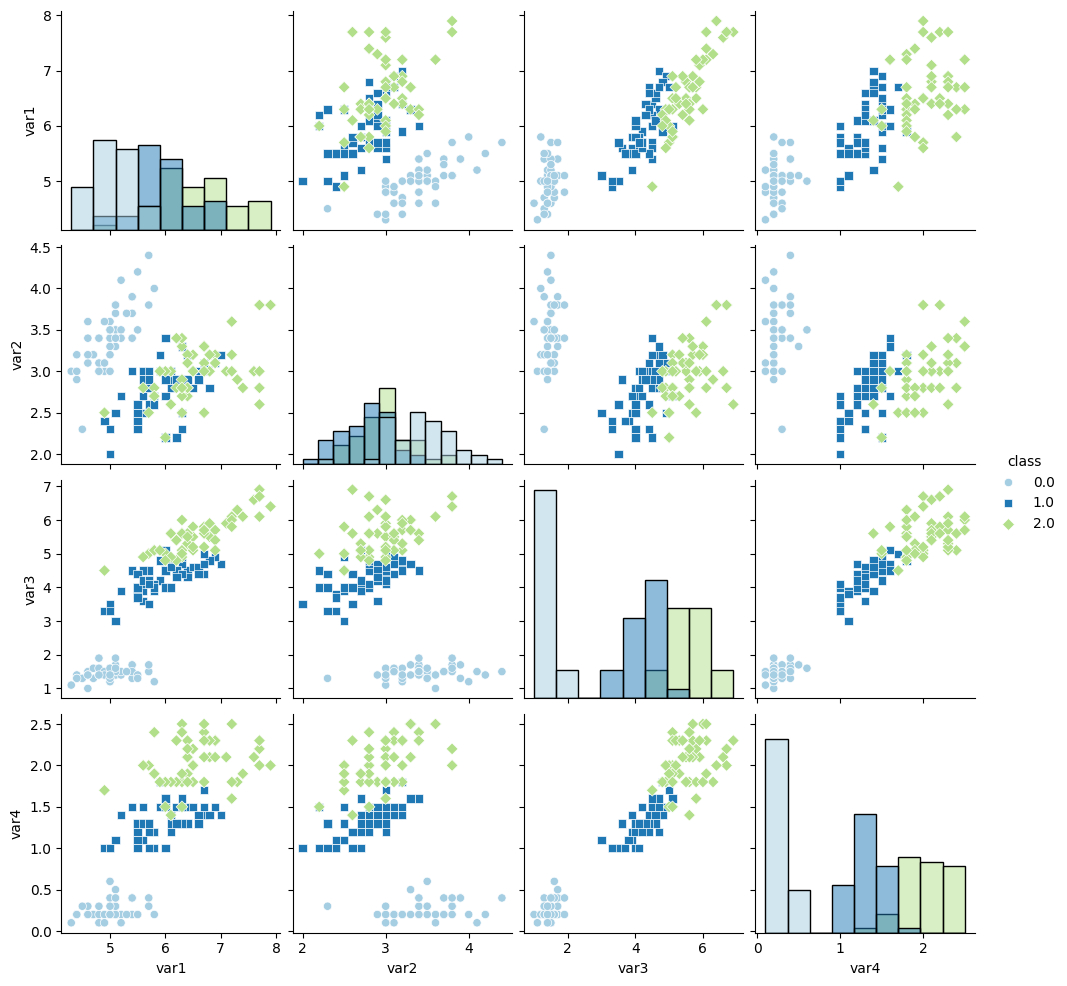

In [104]:
import pandas as pd
df_iris = pd.DataFrame(np.append(iris['data'],np.atleast_2d(iris['target']).T, axis=1))
df_iris.columns =['var1', 'var2', 'var3', 'var4',"class"]
sns.pairplot(df_iris,hue="class", diag_kind="hist", markers=["o", "s", "D"], palette="Paired")

In [112]:
x_train, x_test, y_train, y_test =train_test_split(iris['data'], iris['target'], train_size=0.7, test_size=0.3, random_state=13)

# Dataset

se usa en este programa el *iris-dataset* que tiene 3 clases ***"Iris-setosa","Iris-versicolor","Iris-virginica"***, cada uno tiene 50 instancias, dando un total de *150*. 

In [113]:
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 105
Number of original test examples: 45


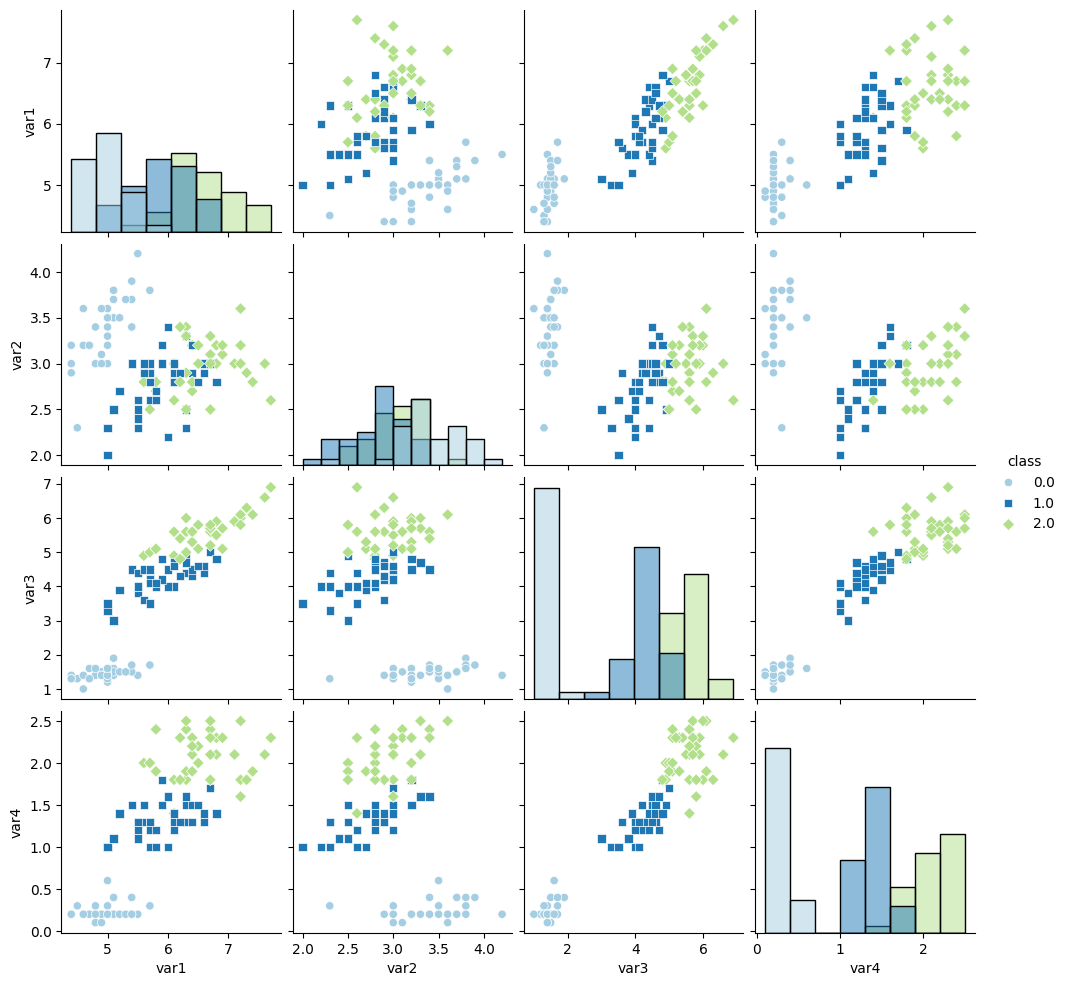

In [114]:
df_train = pd.DataFrame(np.append(x_train,np.atleast_2d(y_train).T, axis=1))
df_train.columns =['var1', 'var2', 'var3', 'var4',"class"]
sns.pairplot(df_iris,hue="class", diag_kind="hist", markers=["o", "s", "D"], palette="Paired")

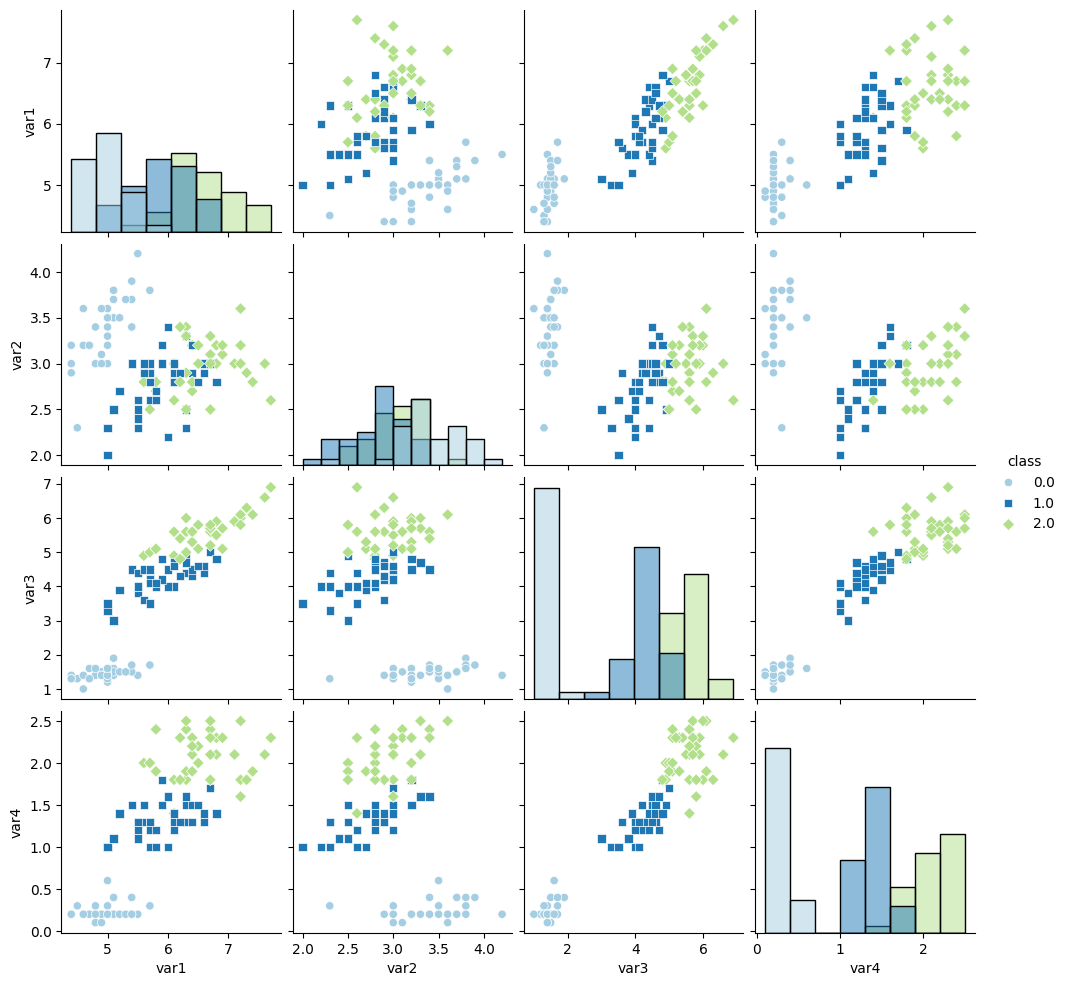

In [115]:
df_test = pd.DataFrame(np.append(x_test,np.atleast_2d(y_test).T, axis=1))
df_test.columns =['var1', 'var2', 'var3', 'var4',"class"]
sns.pairplot(df_iris,hue="class", diag_kind="hist", markers=["o", "s", "D"], palette="Paired")

# algorithm

Convert a integer value i na bin representation to qiskit

In [116]:
def indexPosicion(value):
    list_bin = []
    temp = bin(value)[2:]
    temp = temp[::-1]
    for i in range(len(temp)):
        if temp[i] == '1':
            list_bin.append(i)
    return list_bin

In [128]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

In [129]:
x_train[0]

array([7.2, 3.6, 6.1, 2.5])

In [130]:
y_train

array([2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1, 0, 1, 2, 2, 0, 0, 2, 1, 2, 2, 0,
       2, 1, 1, 0, 0, 0, 1, 1, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 0, 1, 2, 1,
       0, 0, 1, 1, 0, 1, 2, 0, 2, 1, 0, 2, 0, 0, 0, 1, 0, 1, 1, 2, 2, 0,
       1, 0, 1, 1, 2, 0, 2, 0, 1, 0, 2, 2, 0, 1, 1, 2, 1, 2, 2, 0, 0, 1,
       1, 0, 0, 0, 0, 2, 2, 0, 1, 1, 1, 2, 2, 1, 0, 1, 1])

In [131]:
def qram(qc,address,ancilla,oracle,data,train_set,y_train,len_arr):
    if len_arr > len(train_set):
        len_arr = len(train_set)
    for i in range(len_arr):
        x_gates_array = indexPosicion(i)
        if x_gates_array:
            qc.x(address[x_gates_array])
            qc.mcx(address,ancilla)
            angles = train_set[i]
            for index in range(len(angles)):
                qc.cry(angles[index],ancilla, data[index])
            qc.mcx(address,ancilla)
            qc.x(address[x_gates_array])
        else:
            qc.mcx(address,ancilla)
            angles = train_set[i]
            for index in range(len(angles)):
                qc.cry(angles[index],ancilla, data[index])
            qc.mcx(address,ancilla)
 
        qc.barrier()

In [132]:
def qram_d(qc,address,ancilla,data,train_set,len_arr):
    if len_arr > len(train_set):
        len_arr = len(train_set)
    for i in range(len_arr):
        x_gates_array = indexPosicion(i)
        if x_gates_array:
            qc.x(address[x_gates_array])
            qc.mcx(address,ancilla)
            angles = train_set[i]
            for index in range(len(angles)):
                qc.cry(-angles[index],ancilla, data[index])
            qc.mcx(address,ancilla)
            qc.x(address[x_gates_array])
        else:
            qc.mcx(address,ancilla)
            angles = train_set[i]
            for index in range(len(angles)):
                qc.cry(-angles[index],ancilla, data[index])
            qc.mcx(address,ancilla)
        qc.barrier()

In [133]:
def knn_1_V2(input_a, train_set,y_train,size):
    address = QuantumRegister(size)
    ancilla = QuantumRegister(1)
    data_train = QuantumRegister(4)
    data_test = QuantumRegister(4)
    swap_test = QuantumRegister(1)
    oracle = QuantumRegister(1)
    c = ClassicalRegister(size)
    c_oracle = ClassicalRegister(1)
    qc = QuantumCircuit(address, ancilla, data_train, data_test, swap_test,oracle, c,c_oracle)

    qc.h(address)
    qc.x(oracle)
    qc.h(oracle)
    qc.h(swap_test)
    
    qc.barrier()
    
    
    n = (2**size)
    for index in range(1):
        qram(qc,address,ancilla,oracle,data_train,train_set,y_train,n)
        qc.barrier()
        angles = input_a

        for index in range(len(angles)):
            qc.ry(angles[index],data_test[index]) 
        qc.barrier()
        for i in range(4):
            qc.cswap(swap_test[0],data_train[i],data_test[i])
        qc.h(swap_test)
        qc.barrier()

        qc.measure(swap_test,c_oracle)
        qc.x(oracle).c_if(c_oracle[0], 0)

        qc.barrier()
        qram_d(qc,address,ancilla,data_train,train_set,n)
        qc.barrier()    
        qc.append(diffuser(size),address)#[address[0],address[1],address[2],address[3]])  
        qc.barrier() 

    qc.x(address)
    qc.measure(address,c)
    #qc.measure([address[0], address[1],address[2], address[3]],c)   
    
    return qc

In [134]:
import operator
from sklearn.metrics import confusion_matrix

acc_8 = []
acc_16 = []
acc_32 = []
acc_64 = []
acc_128 = []

for iteration in range(10):
    for size in range(3,8):
        result_lista = []
        y_pred = []
        counts_l = []
        k = len(y_test)
        for i in range(k):
            qc = knn_1_V2(x_test[i], x_train,y_train,size)
            simulator = Aer.get_backend('qasm_simulator')
            job = execute(qc, simulator, shots=8192)
            result = job.result()
            counts = result.get_counts(qc)
            counts_l.append(counts)
            salida = '00000'
            while salida[0] != '1':
                salida = max(counts.items(), key=operator.itemgetter(1))[0]
                del counts[salida]
            y_pred.append(y_train[int(salida[1:], 2)])
            result_lista.append([y_pred[i], y_test[i]])

        cf_matrix = confusion_matrix(y_test[:k], y_pred)
        acc_knn = (cf_matrix[0][0]+cf_matrix[1][1]+cf_matrix[2][2])/sum(cf_matrix)*100
        if size == 3:
            acc_8.append(acc_knn)

        elif size == 4:
            acc_16.append(acc_knn)

        elif size == 5:
            acc_32.append(acc_knn)

        if size == 6:
            acc_64.append(acc_knn)
        else:
            acc_128.append(acc_knn)

        print("train set: ",size,"Accuracy: ",acc_knn)

NameError: name 'Aer' is not defined

In [63]:
a_8= 62.22222222222222+62.22222222222222+62.22222222222222+62.22222222222222+62.22222222222222+62.22222222222222+62.22222222222222+62.22222222222222+62.22222222222222+62.22222222222222

a_16=95.55555555555556 + 93.33333333333333 +93.33333333333333+88.88888888888889+97.77777777777777+91.11111111111111+97.77777777777777+91.11111111111111+97.77777777777777+93.33333333333333

a_32=86.66666666666667+88.88888888888889+97.77777777777777+95.55555555555556+91.11111111111111+88.88888888888889+93.33333333333333+97.77777777777777+91.11111111111111+93.33333333333333

a_64=95.55555555555556+95.55555555555556+91.11111111111111+91.11111111111111+93.33333333333333+95.55555555555556+93.33333333333333+91.11111111111111+95.55555555555556+91.11111111111111

a_128=95.55555555555556+86.66666666666667+91.11111111111111+91.11111111111111+95.55555555555556+88.88888888888889+91.11111111111111+97.77777777777777+88.88888888888889+100.0

a_8/10,a_16/10,a_32/10,a_64/10,a_128/10

(62.222222222222214,
 94.00000000000001,
 92.44444444444444,
 93.33333333333334,
 92.66666666666667)

In [58]:
def mae_acc(acc):
    mean =  np.mean(np.asarray(acc))
    n = len(acc)
    summ = 0
    for i in range(n):
        summ += abs(mean - acc[i])
    return summ/n

mae_acc(acc_8),mae_acc(acc_16),mae_acc(acc_32),mae_acc(acc_64),mae_acc(acc_128)

(7.105427357601002e-15,
 2.57777777777778,
 3.1111111111111085,
 1.77777777777778,
 11.555555555555552)

In [ ]:
def knn_1_V3(input_a, train_set,y_train,size):
    address = QuantumRegister(size)
    ancilla = QuantumRegister(1)
    data_train = QuantumRegister(4)
    data_test = QuantumRegister(4)
    swap_test = QuantumRegister(1)
    oracle = QuantumRegister(1)
    c = ClassicalRegister(size)
    c_oracle = ClassicalRegister(1)
    qc = QuantumCircuit(address, ancilla, data_train, data_test, swap_test,oracle, c,c_oracle)

    qc.h(address)
    qc.x(oracle)
    qc.h(oracle)
    qc.h(swap_test)
    
    qc.barrier()
    
    
    n = (2**size)
    for index in range(1):
        qram(qc,address,ancilla,oracle,data_train,train_set,y_train,n)
        qc.barrier()
        angles = input_a

        for index in range(len(angles)):
            qc.ry(angles[index],data_test[index]) 
        qc.barrier()
        for i in range(4):
            qc.fredkin(swap_test[0],data_train[i],data_test[i])
        qc.h(swap_test)
        qc.barrier()

        qc.measure(swap_test,c_oracle)
        qc.x(oracle).c_if(c_oracle[0], 0)

        
        for index in range(len(angles)):
            qc.ry(-angles[index],data_test[index]) 
        qc.barrier()
        qc.barrier()
        qram_d(qc,address,ancilla,data_train,train_set,n)
        qc.barrier()    
        qc.append(diffuser(size),address)#[address[0],address[1],address[2],address[3]])  
        qc.barrier() 

    qc.x(address)
    qc.measure(address,c)
    #qc.measure([address[0], address[1],address[2], address[3]],c)   
    
    return qc

In [59]:
import operator
from sklearn.metrics import confusion_matrix

acc_8 = []
acc_16 = []
acc_32 = []
acc_64 = []
acc_128 = []

for iteration in range(10):
    for size in range(3,8):
        result_lista = []
        y_pred = []
        counts_l = []
        k = len(y_test)
        for i in range(k):
            qc = knn_1_V3(x_test[i], x_train,y_train,size)
            simulator = Aer.get_backend('qasm_simulator')
            job = execute(qc, simulator, shots=8192)
            result = job.result()
            counts = result.get_counts(qc)
            counts_l.append(counts)
            salida = '00000'
            while salida[0] != '1':
                salida = max(counts.items(), key=operator.itemgetter(1))[0]
                del counts[salida]
            y_pred.append(y_train[int(salida[1:], 2)])
            result_lista.append([y_pred[i], y_test[i]])

        cf_matrix = confusion_matrix(y_test[:k], y_pred)
        acc_knn = (cf_matrix[0][0]+cf_matrix[1][1]+cf_matrix[2][2])/sum(cf_matrix)*100
        if size == 3:
            acc_8.append(acc_knn)

        elif size == 4:
            acc_16.append(acc_knn)

        elif size == 5:
            acc_32.append(acc_knn)

        if size == 6:
            acc_64.append(acc_knn)
        else:
            acc_128.append(acc_knn)

        print("train set: ",size,"Accuracy: ",acc_knn)

train set:  3 Accuracy:  62.22222222222222
train set:  4 Accuracy:  93.33333333333333
train set:  5 Accuracy:  93.33333333333333
train set:  6 Accuracy:  88.88888888888889
train set:  7 Accuracy:  97.77777777777777
train set:  3 Accuracy:  62.22222222222222
train set:  4 Accuracy:  95.55555555555556
train set:  5 Accuracy:  91.11111111111111
train set:  6 Accuracy:  93.33333333333333
train set:  7 Accuracy:  93.33333333333333
train set:  3 Accuracy:  62.22222222222222
train set:  4 Accuracy:  91.11111111111111
train set:  5 Accuracy:  88.88888888888889
train set:  6 Accuracy:  84.44444444444444
train set:  7 Accuracy:  97.77777777777777
train set:  3 Accuracy:  62.22222222222222
train set:  4 Accuracy:  95.55555555555556
train set:  5 Accuracy:  95.55555555555556
train set:  6 Accuracy:  88.88888888888889
train set:  7 Accuracy:  91.11111111111111
train set:  3 Accuracy:  62.22222222222222
train set:  4 Accuracy:  95.55555555555556
train set:  5 Accuracy:  95.55555555555556
train set: 

In [60]:
def mae_acc(acc):
    mean =  np.mean(np.asarray(acc))
    n = len(acc)
    summ = 0
    for i in range(n):
        summ += abs(mean - acc[i])
    return mean,summ/n

mae_acc(acc_8),mae_acc(acc_16),mae_acc(acc_32),mae_acc(acc_64),mae_acc(acc_128)

((62.222222222222214, 7.105427357601002e-15),
 (93.99999999999999, 2.0),
 (92.88888888888889, 2.22222222222222),
 (91.55555555555556, 3.5555555555555545),
 (85.44444444444444, 11.611111111111112))